# マルコフ連鎖モンテカルロ法 (MCMC)
前節では解析的に事後分布の計算をした．事後分布を近似的に推論する方法の1つに**マルコフ連鎖モンテカルロ法 (Markov chain Monte Carlo methods; MCMC)** がある．他の近似推論の手法としてはLaplace近似や変分推論（variational inference）などがある．MCMCは他の手法に比して，事後分布の推論だけでなく，確率分布を神経活動で表現する方法を提供するという利点がある．

データを$X$とし，パラメータを$\theta$とする．

$$
\begin{equation}
p(\theta\mid X)=\frac{p(X\mid \theta)p(\theta)}{\int p(X\mid \theta)p(\theta)d\theta}
\end{equation}
$$

分母の積分計算$\int p(X\mid \theta)p(\theta)d\theta$が求まればよい．

### モンテカルロ法

### マルコフ連鎖


## Metropolis-Hastings法


In [1]:
using Base: @kwdef
using PyPlot, LinearAlgebra, Random, Distributions, ForwardDiff, KernelDensity, StatsBase
rc("axes.spines", top=false, right=false)

Metropolis-Hastings法における採用・不採用アルゴリズム．

In [2]:
# Metropolis-Hastings method; log_p: unnormalized log-posterior
function gaussian_mh(log_p::Function, θ_init::Vector{Float64}, σ::Float64, num_iter::Int)
    d = length(θ_init)
    samples = zeros(d, num_iter)
    num_accepted = 0
    θ = θ_init # init position
    for m in 1:num_iter
        θ_ = rand(MvNormal(θ, σ*I))
        mH = log_p(θ) + logpdf(MvNormal(θ, σ*I), θ_)       # initial Hamiltonian
        mH_ = log_p(θ_) + logpdf(MvNormal(θ_, σ*I), θ)    # final Hamiltonian
        
        if min(1, exp(mH_ - mH)) > rand()
            θ = θ_ # accept
            num_accepted += 1
        end
        samples[:, m] = θ
    end
    return samples, num_accepted
end;

## ランジュバン・モンテカルロ法 (LMC)
拡散過程

$$
\begin{equation}
{\frac{d\theta}{dt}}=\nabla \log p (\theta)+{\sqrt 2}{d{W}}
\end{equation}
$$

Euler–Maruyama法により，

In [3]:
# Hamiltonian Monte Carlo method; log_p: unnormalized log-posterior
function lmc(log_p::Function, θ_init::Vector{Float64}, ϵ::Float64, num_iter::Int; β=1)
    grad(θ)= ForwardDiff.gradient(log_p, θ)
    d = length(θ_init)
    samples = zeros(d, num_iter)
    num_accepted = 0
    θ = θ_init # init position
    ρ = sqrt(2*ϵ);
    for m in 1:num_iter
        θ += ϵ * β * grad(θ) + ρ * randn(d)
        samples[:, m] = θ
    end
    return samples
end;

## ハミルトニアン・モンテカルロ法 (HMC法)

LMCよりも一般的なMCMCの手法としてHamiltonianモンテカルロ法(Hamiltonian Monte Calro; HMC)あるいはハイブリッド・モンテカルロ法(Hybrid Monte Calro)がある．エネルギーポテンシャルの局面上をHamilton力学に従ってパラメータを運動させることにより高速にサンプリングする手法である．

一般化座標を$\mathbf{q}$, 一般化運動量を$\mathbf{p}$とする．ポテンシャルエネルギーを$U(\mathbf{q})$としたとき，古典力学（解析力学）において保存力のみが作用する場合の**ハミルトニアン (Hamiltonian)** $\mathcal{H}(\mathbf{q}, \mathbf{p})$は

$$
\begin{equation}
\mathcal{H}(\mathbf{q}, \mathbf{p}):=U(\mathbf{q})+\frac{1}{2}\|\mathbf{p}\|^2
\end{equation}
$$

となる．このとき，次の2つの方程式が成り立つ．

$$
\begin{equation}
\frac{d\mathbf{q}}{dt}=\frac{\partial \mathcal{H}}{\partial \mathbf{p}}=\mathbf{p},\quad\frac{d\mathbf{p}}{dt}=-\frac{\partial \mathcal{H}}{\partial \mathbf{q}}=-\frac{\partial U}{\partial \mathbf{q}}
\end{equation}
$$

これを**ハミルトンの運動方程式(hamilton's equations of motion)** あるいは**正準方程式 (canonical equations)** という．



リープフロッグ(leap frog)法により離散化する．

In [96]:
# Hamiltonian Monte Carlo method; log_p: unnormalized log-posterior
function almc(log_p::Function, θ_init::Vector{Float64}, ϕ, y, ϵ::Float64, num_iter::Int; β=1)
    grad(θ)= ForwardDiff.gradient(log_p, θ)
    d = length(θ_init)
    samples = zeros(d, num_iter)
    drift_term = zeros(num_iter)
    diff_term = zeros(num_iter)
    num_accepted = 0
    θ = θ_init # init position
    ρ = sqrt(2*ϵ);
    for m in 1:num_iter
        error = y .- ϕ * θ;
        loss = sqrt(sum(error .^ 2, dims=1)[1])
        #println(loss)
        drift = ϵ * β * grad(θ)
        diff = ρ * loss * 1e-2 * randn(d)
        θ += diff
        #θ += drift + diff
        samples[:, m] = θ
        drift_term[m] = norm(drift)
        diff_term[m] = norm(diff)
    end
    return samples, drift_term, diff_term
end;

## 線形回帰への適応


In [103]:
# Generate Toy datas
n_train, n_test = 50, 100 # sample size
n_iter = 100000
n_burn_in = round(Int, n_iter / 2)
dims = 4 # dimensions
σy = 0.2

polynomial_expansion(x; degree=3) = stack([x .^ p for p in 0:degree]);

Random.seed!(0);
x = rand(n_train)
y = sin.(2π*x) + σy * randn(n_train);
ϕ = polynomial_expansion(x, degree=dims-1) # design matrix

xtest = range(-0.1, 1.1, length=n_test)
ytest = sin.(2π*xtest)
ϕtest = polynomial_expansion(xtest, degree=dims-1);

In [104]:
log_joint(w, ϕ, y, σy, μ₀, Σ₀) = sum(logpdf.(Normal.(ϕ * w, σy), y)) + logpdf(MvNormal(μ₀, Σ₀), w);

In [105]:
α, β = 5e-3, 5.0

(0.005, 5.0)

In [106]:
w = randn(dims)
μ₀ = zeros(dims)
Σ₀ = 1/α * I;

In [107]:
ulp(w) = log_joint(w, ϕ, y, σy, μ₀, Σ₀)

ulp (generic function with 1 method)

In [108]:
w_init = rand(MvNormal(μ₀, Σ₀), 1)[:, 1]

#@time samples, num_accepted = hmc(ulp, w_init, 1e-2, 10, n_iter)
#@time samples = lmc(ulp, w_init, 1e-3, n_iter)
@time samples_almc, drift_term, diff_term = almc(ulp, w_init, ϕ, y, 1e-3, n_iter)
#@time samples = almc2(ulp, w_init, ϕ, y, 1e-3, n_iter)

  0.713669 seconds (1.88 M allocations: 672.784 MiB, 10.81% gc time, 10.01% compilation time: 44% of which was recompilation)


([21.622458485135986 21.625422393400335 … 5.554519017951961 5.620820212140483; 2.3836497982785265 2.4444352974135968 … 51.70356714179557 51.68878270417049; 4.028994141919254 3.9778765726295795 … -0.1133419426202724 -0.24329198228230947; 12.477352025303876 12.482634289941462 … 3.4181413989017724 3.737464052624403], [43.28415353551644, 43.20231113738066, 43.23042115491818, 43.282978970802304, 43.134022735702416, 43.088331458055926, 43.12145427945381, 43.33760459447885, 43.37217645942025, 43.491431637872076  …  54.684601322048856, 54.68368758623392, 54.566053255141576, 54.72277148335885, 55.016000266646934, 54.938004114319945, 54.95212521077414, 55.122658243412225, 54.91164815418851, 55.1039483496811], [0.11964585545134726, 0.07965280828122313, 0.20347725159861313, 0.13265972807482304, 0.11815929814493314, 0.13507646549057645, 0.187087741395657, 0.04438960136404212, 0.13038370301744695, 0.18350054383638012  …  0.06996502541824623, 0.1583439439926652, 0.35272001472932796, 0.193970156420660

In [109]:
#@time samples2, drift_term2, diff_term2 = lmc2(ulp, w_init, 1e-3, n_iter)

In [110]:
#@time samples = lmc(ulp, w_init, 1e-3, n_iter)

In [111]:
#ratio = diff_term ./ drift_term
#ratio2 = diff_term2 ./ drift_term2

In [112]:
#semilogy(ratio2)
#semilogy(ratio)

In [113]:
#semilogy(ratio)

In [114]:
#semilogy(diff_term)
#semilogy(diff_term2)
#axhline(1, color="tab:red")

In [115]:
#plot(samples[1, :])
#plot(samples_almc[1, :])

In [125]:
norm(samples_almc[:, end])

52.12822369723972

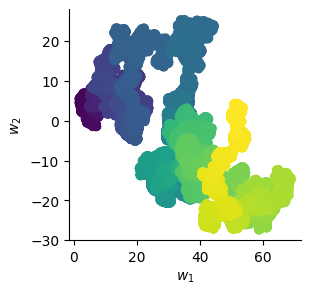

PyObject Text(24.4, 0.5, '$w_2$')

In [116]:
figure(figsize=(3,3))
scatter(samples_almc[2, :], samples_almc[3, :], c=1:n_iter)
xlabel(L"$w_1$")
ylabel(L"$w_2$")
#scatter(samples[1, :], samples[2, :], c=1:n_iter)

In [117]:
#yhmc = ϕtest * samples[:, n_burn_in:end];
yhmc = ϕtest * samples_almc[:, n_burn_in:end];
yhmc_mean = mean(yhmc, dims=2)[:];
yhmc_std = std(yhmc, dims=2)[:];

In [118]:
#error = y .- ϕ * samples;
#loss = sum(error .^ 2, dims=1)

In [119]:
error_almc = y .- ϕ * samples_almc;
loss_almc = sum(error_almc .^ 2, dims=1)

1×100000 Matrix{Float64}:
 39408.2  39459.3  39549.8  39280.7  …  66929.4  66465.5  66917.0  67297.3

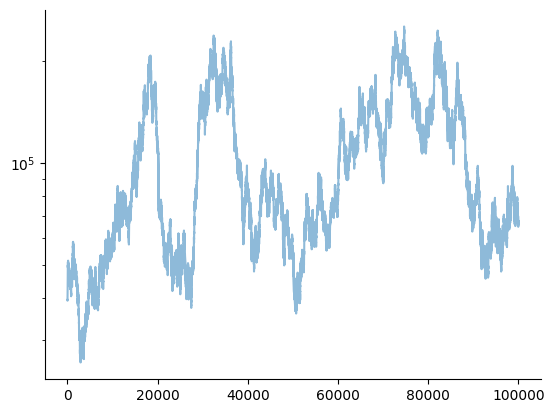

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000266C7C013A0>

In [120]:
#semilogy(loss[1, :])
semilogy(loss_almc[1, :], alpha=0.5)

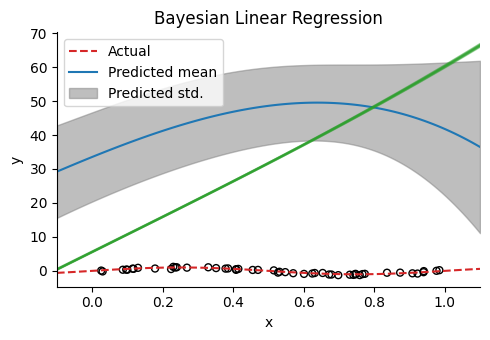

In [121]:
figure(figsize=(5,3.5))
title("Bayesian Linear Regression")
scatter(x, y, facecolor="None", edgecolors="black", s=25) # samples
plot(xtest, ytest, "--", label="Actual", color="tab:red")  # regression line
plot(xtest, yhmc_mean, label="Predicted mean", color="tab:blue")  # regression line
fill_between(xtest, yhmc_mean+yhmc_std, yhmc_mean-yhmc_std, alpha=0.5, color="tab:gray", label="Predicted std.")
for i in 1:10
    plot(xtest, yhmc[:, end-i], alpha=0.3, color="tab:green")
end
xlabel("x"); ylabel("y"); legend()
xlim(-0.1, 1.1); tight_layout()